In [ ]:
from pulp import *

# Create a maximization problem
prob = LpProblem("Land_Allocation_GAMS", LpMaximize)

# Define decision variables (acres for each crop)
X_corn = LpVariable("X_corn", lowBound=0, cat="Continuous")
X_wheat = LpVariable("X_wheat", lowBound=0, cat="Continuous")
X_cotton = LpVariable("X_cotton", lowBound=0, cat="Continuous")

# Objective function: Maximize profit
prob += 109 * X_corn + 90 * X_wheat + 115 * X_cotton, "Total_Profit"

# Constraints
# Land constraint
prob += X_corn + X_wheat + X_cotton <= 1000, "Land_Constraint"

# Labor constraint
prob += 6 * X_corn + 4 * X_wheat + 8 * X_cotton <= 5000, "Labor_Constraint"

# Solve the problem
prob.solve()

# Print results
print("Status:", LpStatus[prob.status])
for v in prob.variables():
    print(f"{v.name} = {v.varValue} acres")
print(f"Total Profit = ${prob.objective.value()}")

Status: Optimal
X_corn = 500.0 acres
X_cotton = 0.0 acres
X_wheat = 500.0 acres
Total Profit = $99500.0


# Supply Chain Optimization

Find the optimal locations of your manufacturing facilities to meet your customers’ demand and reduce production costs

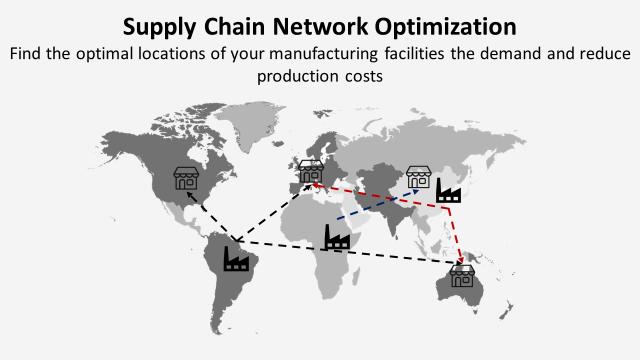

Credit: https://medium.com/data-science/supply-chain-optimization-with-python-23ae9b28fd0b


- 5 markets in Brazil, USA, India, Japan, Germany
- 2 types of manufacturing facilities: low-capacity and high-capacity sites
- Shipping costs ($/container)
- Customer’s demand (Units/year)


In [1]:
import pandas as pd
from pulp import *
import os
# get the current working directory
Dir = r'C:\Users\yi7\Dropbox\UW\Teaching\AAE625\AAE625_25\Git_Code\AAE625Public\supply-chain-optimization-main'

## Plant Location  

#### Manufacturing variable costs

In [2]:
# Import Costs
manvar_costs = pd.read_excel(Dir + '/variable_costs.xlsx', index_col = 0)
manvar_costs

,USA,Germany,Japan,Brazil,India
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
Germany,13,13,13,13,13
Japan,10,10,10,10,10
Brazil,8,8,8,8,8
India,5,5,5,5,5


#### Freight costs

In [5]:
# Import Costs
freight_costs = pd.read_excel(Dir +'/freight_costs.xlsx', index_col = 0)
freight_costs

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,0,12250,1100,16100,8778
Germany,13335,0,8617,20244,10073
Japan,15400,22750,0,43610,14350
Brazil,16450,22050,28000,0,29750
India,13650,15400,24500,29400,0


#### Variable Costs

In [6]:
# Variable Costs
var_cost = freight_costs/1000 + manvar_costs 

var_cost

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,12.000,24.25,13.100,28.100,20.778
Germany,26.335,13.00,21.617,33.244,23.073
Japan,25.400,32.75,10.000,53.610,24.350
Brazil,24.450,30.05,36.000,8.000,37.750
India,18.650,20.40,29.500,34.400,5.000


#### Fixed Costs

In [7]:
# Import Costs
fixed_costs = pd.read_excel(Dir +'/fixed_cost.xlsx', index_col = 0)
fixed_costs

,Low,High
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,6160


#### Plants Capacity

In [21]:
# Two types of plants: Low Capacity and High Capacity Plant
cap = pd.read_excel(Dir +'/capacity.xlsx', index_col = 0)
cap

,Low,High
Capacity (kUnits/month),,
USA,500,1500
Germany,500,1500
Japan,500,1500
Brazil,500,1500
India,500,3000


#### Demand 

In [17]:
# -- Demand
demand = pd.read_excel(Dir +'/demand.xlsx', index_col = 0)
demand

,Demand
(Units/month),
USA,2800000
Germany,90000
Japan,1700000
Brazil,145000
India,160000


In [22]:
# Define Decision Variables
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low', 'High']

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc],
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", 
                     [(i,s) for s in size for i in loc], cat='Binary')

# Define Objective Function
# lpSum is a utility function provided by PuLP to compute the sum of a list of linear expressions or variables.
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s] * y[(i,s)] * 1000 for s in size])


# Define logical constraint: Add a logical constraint so that if the high capacity plant in USA is open, then a low capacity plant in Germany is also opened.
# model += y[('USA','High_Cap')] <= y[('Germany','Low_Cap')]                                                       
                                                       
# Solve Model
model.solve()
print("Total Costs = {:,} ($/Month)".format(int(value(model.objective))))
print('\n' + "Status: {}".format(LpStatus[model.status]))


# Dictionnary
dict_plant = {}
dict_prod = {}
for v in model.variables():
    if 'plant' in v.name:
        name = v.name.replace('plant__', '').replace('_', '')
        dict_plant[name] = int(v.varValue)
        p_name = name
    else:
        name = v.name.replace('production__', '').replace('_', '')
        dict_prod[name] = v.varValue
    print(name, "=", v.varValue)
    


Total Costs = 92,981,000 ($/Month)

Status: Optimal
('Brazil','High') = 0.0
('Brazil','Low') = 1.0
('Germany','High') = 0.0
('Germany','Low') = 0.0
('India','High') = 1.0
('India','Low') = 0.0
('Japan','High') = 1.0
('Japan','Low') = 0.0
('USA','High') = 1.0
('USA','Low') = 0.0
('Brazil','Brazil') = 145000.0
('Brazil','Germany') = 0.0
('Brazil','India') = 0.0
('Brazil','Japan') = 0.0
('Brazil','USA') = 0.0
('Germany','Brazil') = 0.0
('Germany','Germany') = 0.0
('Germany','India') = 0.0
('Germany','Japan') = 0.0
('Germany','USA') = 0.0
('India','Brazil') = 0.0
('India','Germany') = 90000.0
('India','India') = 160000.0
('India','Japan') = 0.0
('India','USA') = 1500000.0
('Japan','Brazil') = 0.0
('Japan','Germany') = 0.0
('Japan','India') = 0.0
('Japan','Japan') = 1500000.0
('Japan','USA') = 0.0
('USA','Brazil') = 0.0
('USA','Germany') = 0.0
('USA','India') = 0.0
('USA','Japan') = 200000.0
('USA','USA') = 1300000.0


c:\Users\yi7\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [11]:
# Capacity Plant
list_low, list_high = [], []
for l in loc:
    for cap in ['Low', 'High']:
        x = "('{}','{}')".format(l, cap)
        if cap == 'Low':
            list_low.append(dict_plant[x])
        else:
            list_high.append(dict_plant[x])
df_capacity = pd.DataFrame({'Location': loc, 'Low': list_low, 'High': list_high}).set_index('Location')
    
df_capacity

,Low,High
Location,,
USA,0,1
Germany,0,0
Japan,0,1
Brazil,1,0
India,0,1
